<a href="https://colab.research.google.com/github/name-is-nambi/branches/blob/main/capstoneproject_rough_version_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("serp_language_ai_generators_2023_01_28.csv", low_memory=False)

# Auto-detect columns safely
desc_col = 'snippet' if 'snippet' in df.columns else 'description'
key_col = 'query' if 'query' in df.columns else 'searchTerms'

df = df[['title', desc_col, key_col, 'rank']]
df.columns = ['title', 'description', 'keyword', 'rank']

df.dropna(inplace=True)
df = df[df['rank'] > 0]

#EDA


In [ ]:
df['top3'] = df['rank'].apply(lambda x: 1 if x <= 3 else 0)

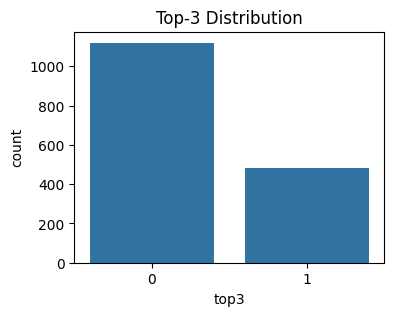

In [ ]:
plt.figure(figsize=(4,3))
sns.countplot(x='top3', data=df)
plt.title("Top-3 Distribution")
plt.show()

#V2 feature engineering
for better socre in f1 ,precison,recall

In [ ]:
df['title_len'] = df['title'].str.len()
df['desc_len'] = df['description'].str.len()

df['title_words'] = df['title'].str.split().apply(len)
df['desc_words'] = df['description'].str.split().apply(len)

In [ ]:
df['kw_in_title'] = df.apply(
    lambda x: 1 if x['keyword'].lower() in x['title'].lower() else 0,
    axis=1
)

df['kw_in_desc'] = df.apply(
    lambda x: 1 if x['keyword'].lower() in x['description'].lower() else 0,
    axis=1
)

In [ ]:
df['kw_density_title'] = df.apply(
    lambda x: x['title'].lower().count(x['keyword'].lower()) / max(len(x['title'].split()),1),
    axis=1
)

df['kw_density_desc'] = df.apply(
    lambda x: x['description'].lower().count(x['keyword'].lower()) / max(len(x['description'].split()),1),
    axis=1
)

In [ ]:
df['kw_pos_title'] = df.apply(
    lambda x: x['title'].lower().find(x['keyword'].lower())
    if x['keyword'].lower() in x['title'].lower() else -1,
    axis=1
)

In [ ]:
df['title_desc_ratio'] = df['title_len'] / (df['desc_len'] + 1)

In [ ]:
df['early_kw_score'] = df['kw_pos_title'] / (df['title_len'] + 1)

#Model part summa


#X&Y

In [ ]:
X = df[['title_len','desc_len',
        'title_words','desc_words',
        'kw_in_title','kw_in_desc',
        'kw_density_title','kw_density_desc',
        'kw_pos_title','title_desc_ratio',
        'early_kw_score']]

y = df['top3']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=42
)

model.fit(X_train_sm, y_train_sm)

RandomForestClassifier(class_weight='balanced', min_samples_leaf=2,
                       n_estimators=300, random_state=42)

In [ ]:
y_pred = model.predict(X_test)

#Metric after v2 feature engineering

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.796875
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       224
           1       0.67      0.64      0.65        96

    accuracy                           0.80       320
   macro avg       0.76      0.75      0.75       320
weighted avg       0.79      0.80      0.80       320

[[194  30]
 [ 35  61]]


In [ ]:
y_prob = model.predict_proba(X_test)[:,1]

threshold = 0.4
y_pred_new = (y_prob >= threshold).astype(int)

print("After Threshold Tuning:")
print(classification_report(y_test, y_pred_new))
print(confusion_matrix(y_test, y_pred_new))

After Threshold Tuning:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       224
           1       0.63      0.74      0.68        96

    accuracy                           0.79       320
   macro avg       0.76      0.78      0.76       320
weighted avg       0.81      0.79      0.80       320

[[183  41]
 [ 25  71]]


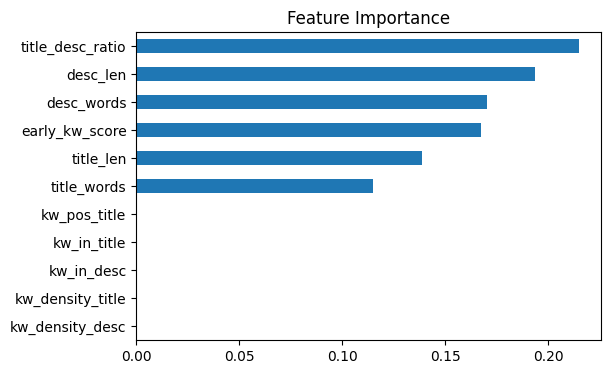

In [ ]:
importance = pd.Series(model.feature_importances_, index=X.columns)

plt.figure(figsize=(6,4))
importance.sort_values().plot(kind='barh')
plt.title("Feature Importance")
plt.show()

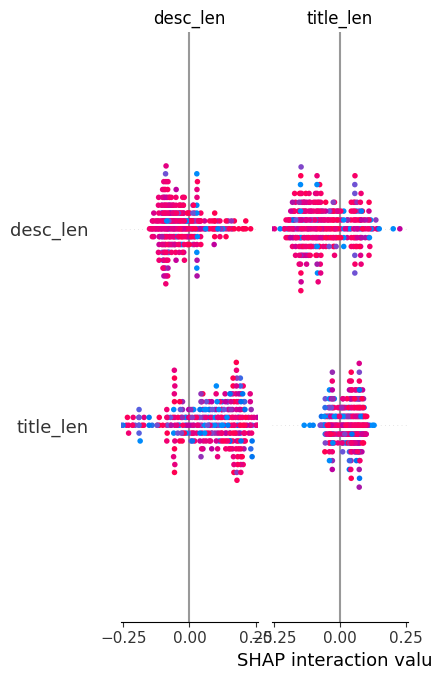

In [ ]:
import shap

explainer = shap.TreeExplainer(model)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

In [ ]:
def predict_seo(title, description, keyword):

    title_len = len(title)
    desc_len = len(description)

    title_words = len(title.split())
    desc_words = len(description.split())

    kw_in_title = 1 if keyword.lower() in title.lower() else 0
    kw_in_desc = 1 if keyword.lower() in description.lower() else 0

    kw_density_title = title.lower().count(keyword.lower()) / max(title_words,1)
    kw_density_desc = description.lower().count(keyword.lower()) / max(desc_words,1)

    kw_pos_title = title.lower().find(keyword.lower()) if kw_in_title else -1

    title_desc_ratio = title_len / (desc_len + 1)

    early_kw_score = kw_pos_title / (title_len + 1)

    input_data = pd.DataFrame([[
        title_len, desc_len,
        title_words, desc_words,
        kw_in_title, kw_in_desc,
        kw_density_title, kw_density_desc,
        kw_pos_title, title_desc_ratio,
        early_kw_score
    ]], columns=X.columns)

    prediction = model.predict(input_data)[0]
    if prediction == 0:
      print("no")
    else:
      print("yes")
    probability = model.predict_proba(input_data)[0][1]

    return prediction, probability

In [ ]:
title = "Best AI Content Generator for SEO"
description = "Discover the best AI content generator tools to improve SEO ranking."
keyword = "AI content generator"

result, prob = predict_seo(title, description, keyword)

print("Top-3 Prediction:", result)
print("Probability:", prob)

no
Top-3 Prediction: 0
Probability: 0.4417609356874062


#MODULE 1 — Competitor Scraping

In [ ]:
!pip install beautifulsoup4 scikit-learn requests

In [ ]:
import requests
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Predefined competitor pages (safe alternative to live SERP scraping)

links = [
    "https://www.semrush.com/blog/ai-content-generator/",
    "https://writesonic.com/blog/ai-content-generator/",
    "https://www.copy.ai/blog/ai-content-generator/"
]

In [ ]:
def scrape_page_details(url):

    headers = {"User-Agent": "Mozilla/5.0"}

    try:
        r = requests.get(url, headers=headers, timeout=10)
        soup = BeautifulSoup(r.text, "html.parser")

        title = soup.title.string if soup.title else "No title"

        paragraphs = soup.find_all("p")
        text = " ".join([p.get_text() for p in paragraphs])

        word_count = len(text.split())
        img_count = len(soup.find_all("img"))

        # Content type classification
        if word_count > 1500:
            content_type = "Guide / Long-form"
        elif word_count > 600:
            content_type = "Informative Blog"
        else:
            content_type = "Short Article"

        return {
            "title": title,
            "url": url,
            "word_count": word_count,
            "images": img_count,
            "content_type": content_type,
            "text": text
        }

    except Exception as e:
        print("Error scraping:", url)
        return None

In [ ]:
competitors = []

for link in links:
    info = scrape_page_details(link)
    if info:
        competitors.append(info)

print("Competitors found:", len(competitors))

Error scraping: https://writesonic.com/blog/ai-content-generator/
Competitors found: 2


In [ ]:
for c in competitors:
    print("\n--- Competitor ---")
    print("Title:", c["title"])
    print("URL:", c["url"])
    print("Word Count:", c["word_count"])
    print("Images:", c["images"])
    print("Type:", c["content_type"])




--- Competitor ---
Title: 
                
    Page not found | Semrush

            
URL: https://www.semrush.com/blog/ai-content-generator/
Word Count: 173
Images: 0
Type: Short Article

--- Competitor ---
Title: AI Content Generator: Scale with Creativity | Copy.ai
URL: https://www.copy.ai/blog/ai-content-generator/
Word Count: 1066
Images: 10
Type: Informative Blog


In [ ]:
def extract_keywords(text, top_n=15):

    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform([text])

    scores = zip(vectorizer.get_feature_names_out(), X.toarray()[0])
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)

    return [word for word, score in sorted_scores[:top_n]]

In [ ]:
def content_gap_analysis(user_text, competitors):

    user_keywords = set(extract_keywords(user_text))

    comp_keywords = set()

    for c in competitors:
        comp_keywords.update(extract_keywords(c["text"]))

    missing_keywords = comp_keywords - user_keywords

    return list(missing_keywords)

In [ ]:
user_text = "AI content generator tools help create SEO content automatically."

missing = content_gap_analysis(user_text, competitors)

print("Missing Keywords:")
print(missing[:15])

Missing Keywords:
['learn', 'organizations', 'site', 'browser', 'approach', 'workflows', 'generators', 'creation', 'chatgpt', 'step', 'copy', 'keyword', 'operating', 'businesses', 'driven']


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
def build_competitor_table(competitors):

    data = []

    for c in competitors:
        data.append({
            "Title": c["title"],
            "URL": c["url"],
            "Word Count": c["word_count"],
            "Images": c["images"],
            "Content Type": c["content_type"]
        })

    return pd.DataFrame(data)

In [ ]:
comp_table = build_competitor_table(competitors)
comp_table

,Title,URL,Word Count,Images,Content Type
0,\n \n Page not found | Semru...,https://www.semrush.com/blog/ai-content-genera...,173,0,Short Article
1,AI Content Generator: Scale with Creativity | ...,https://www.copy.ai/blog/ai-content-generator/,1066,10,Informative Blog


In [ ]:
def extract_keywords(text, top_n=20):

    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform([text])

    scores = zip(vectorizer.get_feature_names_out(), X.toarray()[0])
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)

    return [word for word, score in sorted_scores[:top_n]]

In [ ]:
def compare_with_competitors(user_text, competitors):

    user_keywords = set(extract_keywords(user_text))

    comp_keywords = set()
    for c in competitors:
        comp_keywords.update(extract_keywords(c["text"]))

    missing = comp_keywords - user_keywords
    common = user_keywords & comp_keywords

    return list(common), list(missing)

In [ ]:
def generate_seo_suggestions(user_text, competitors):

    common, missing = compare_with_competitors(user_text, competitors)

    avg_words = int(sum(c["word_count"] for c in competitors) / len(competitors))
    avg_images = int(sum(c["images"] for c in competitors) / len(competitors))

    suggestions = {
        "Add These Keywords": missing[:10],
        "Keep These Strong Keywords": common[:10],
        "Recommended Word Count": avg_words,
        "Recommended Image Count": avg_images
    }

    return suggestions

In [ ]:
user_text = "AI content generator tools help create SEO content automatically."
user_topic = "AI Content Generators for SEO"

In [ ]:
comp_table

,Title,URL,Word Count,Images,Content Type
0,\n \n Page not found | Semru...,https://www.semrush.com/blog/ai-content-genera...,173,0,Short Article
1,AI Content Generator: Scale with Creativity | ...,https://www.copy.ai/blog/ai-content-generator/,1066,10,Informative Blog


In [ ]:
common, missing = compare_with_competitors(user_text, competitors)

print("Common Keywords:", common[:10])
print("Missing Keywords:", missing[:10])

Common Keywords: ['tools', 'ai', 'seo', 'content']
Missing Keywords: ['learn', 'organizations', 'site', 'browser', 'approach', 'average', 'workflows', 'brand', 'generators', 'creation']


In [ ]:
suggestions = generate_seo_suggestions(user_text, competitors)

for k, v in suggestions.items():
    print(k, ":", v)

Add These Keywords : ['learn', 'organizations', 'site', 'browser', 'approach', 'average', 'workflows', 'brand', 'generators', 'creation']
Keep These Strong Keywords : ['tools', 'ai', 'seo', 'content']
Recommended Word Count : 619
Recommended Image Count : 5
